## **Data preparation for Demand Forecasting with GRU [M5 Forecasting (Walmart)]**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt


from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


warnings.filterwarnings("ignore")

### **Reading datasets**

In [2]:
calender_df = pd.read_csv("../data/m5-forecasting-accuracy (1)/calendar.csv")
sales_train_evaluation_df = pd.read_csv("../data/m5-forecasting-accuracy (1)/sales_train_evaluation.csv")
sales_train_validation_df = pd.read_csv("../data/m5-forecasting-accuracy (1)/sales_train_validation.csv")
sell_prices_df = pd.read_csv("../data/m5-forecasting-accuracy (1)/sell_prices.csv")
sample_submission_df = pd.read_csv("../data/m5-forecasting-accuracy (1)/sample_submission.csv")

In [3]:
calender_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [17]:
sales_train_validation_df.groupby(sales_train_validation_df['store_id']).sum().drop(columns=['id', 'item_id', 'dept_id', 'cat_id', 'state_id']).T

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
d_1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
d_2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
d_3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317
d_4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211
d_5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132
...,...,...,...,...,...,...,...,...,...,...
d_1909,3722,3691,5235,2500,2901,3384,3315,3242,4194,3159
d_1910,3709,3303,5018,2458,2776,3446,3380,3324,4393,3226
d_1911,4387,4457,5623,2628,3022,3902,3691,3991,4988,3828
d_1912,5577,5884,7419,2954,3700,4483,4083,4772,5404,4686


#### **Extracting dates**

In [20]:
date_index = calender_df['date']

- total dates in the calender df are 1969 
- but we have sells data for 1913 dates only

In [24]:
dates = date_index[:1913]

In [26]:
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [27]:
dates_list

[datetime.date(2011, 1, 29),
 datetime.date(2011, 1, 30),
 datetime.date(2011, 1, 31),
 datetime.date(2011, 2, 1),
 datetime.date(2011, 2, 2),
 datetime.date(2011, 2, 3),
 datetime.date(2011, 2, 4),
 datetime.date(2011, 2, 5),
 datetime.date(2011, 2, 6),
 datetime.date(2011, 2, 7),
 datetime.date(2011, 2, 8),
 datetime.date(2011, 2, 9),
 datetime.date(2011, 2, 10),
 datetime.date(2011, 2, 11),
 datetime.date(2011, 2, 12),
 datetime.date(2011, 2, 13),
 datetime.date(2011, 2, 14),
 datetime.date(2011, 2, 15),
 datetime.date(2011, 2, 16),
 datetime.date(2011, 2, 17),
 datetime.date(2011, 2, 18),
 datetime.date(2011, 2, 19),
 datetime.date(2011, 2, 20),
 datetime.date(2011, 2, 21),
 datetime.date(2011, 2, 22),
 datetime.date(2011, 2, 23),
 datetime.date(2011, 2, 24),
 datetime.date(2011, 2, 25),
 datetime.date(2011, 2, 26),
 datetime.date(2011, 2, 27),
 datetime.date(2011, 2, 28),
 datetime.date(2011, 3, 1),
 datetime.date(2011, 3, 2),
 datetime.date(2011, 3, 3),
 datetime.date(2011, 3, 4)

In [28]:
sales_train_validation_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


#### **Creating a new column in the dataset**

In [29]:
sales_train_validation_df['item_id_store_id'] = sales_train_validation_df['item_id'] + '_' + sales_train_validation_df['store_id']

In [30]:
sales_train_validation_df['item_id_store_id']

0        HOBBIES_1_001_CA_1
1        HOBBIES_1_002_CA_1
2        HOBBIES_1_003_CA_1
3        HOBBIES_1_004_CA_1
4        HOBBIES_1_005_CA_1
                ...        
30485      FOODS_3_823_WI_3
30486      FOODS_3_824_WI_3
30487      FOODS_3_825_WI_3
30488      FOODS_3_826_WI_3
30489      FOODS_3_827_WI_3
Name: item_id_store_id, Length: 30490, dtype: object

In [54]:
sales_df = sales_train_validation_df.loc[:,'d_1':'d_1913'].T

In [55]:
sales_df

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
d_5,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1909,1,1,1,0,1,0,1,4,0,0,...,4,1,1,0,0,0,0,1,1,0
d_1910,3,0,0,1,2,0,0,6,0,0,...,2,3,3,0,2,1,0,0,0,0
d_1911,0,0,1,3,2,2,0,3,0,2,...,0,1,6,0,3,0,0,0,3,0
d_1912,1,0,1,7,2,0,1,2,0,0,...,3,0,0,4,2,0,1,1,1,0


In [56]:
sales_df.columns = sales_train_validation_df['item_id_store_id'].values

In [57]:
sales_df

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
d_5,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1909,1,1,1,0,1,0,1,4,0,0,...,4,1,1,0,0,0,0,1,1,0
d_1910,3,0,0,1,2,0,0,6,0,0,...,2,3,3,0,2,1,0,0,0,0
d_1911,0,0,1,3,2,2,0,3,0,2,...,0,1,6,0,3,0,0,0,3,0
d_1912,1,0,1,7,2,0,1,2,0,0,...,3,0,0,4,2,0,1,1,1,0


In [58]:
sales_df = pd.DataFrame(sales_df).set_index([dates_list])

In [59]:
sales_df.index = pd.to_datetime(sales_df.index)

In [60]:
sales_df

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,1,1,1,0,1,0,1,4,0,0,...,4,1,1,0,0,0,0,1,1,0
2016-04-21,3,0,0,1,2,0,0,6,0,0,...,2,3,3,0,2,1,0,0,0,0
2016-04-22,0,0,1,3,2,2,0,3,0,2,...,0,1,6,0,3,0,0,0,3,0
2016-04-23,1,0,1,7,2,0,1,2,0,0,...,3,0,0,4,2,0,1,1,1,0


#### **Time Series Plot**

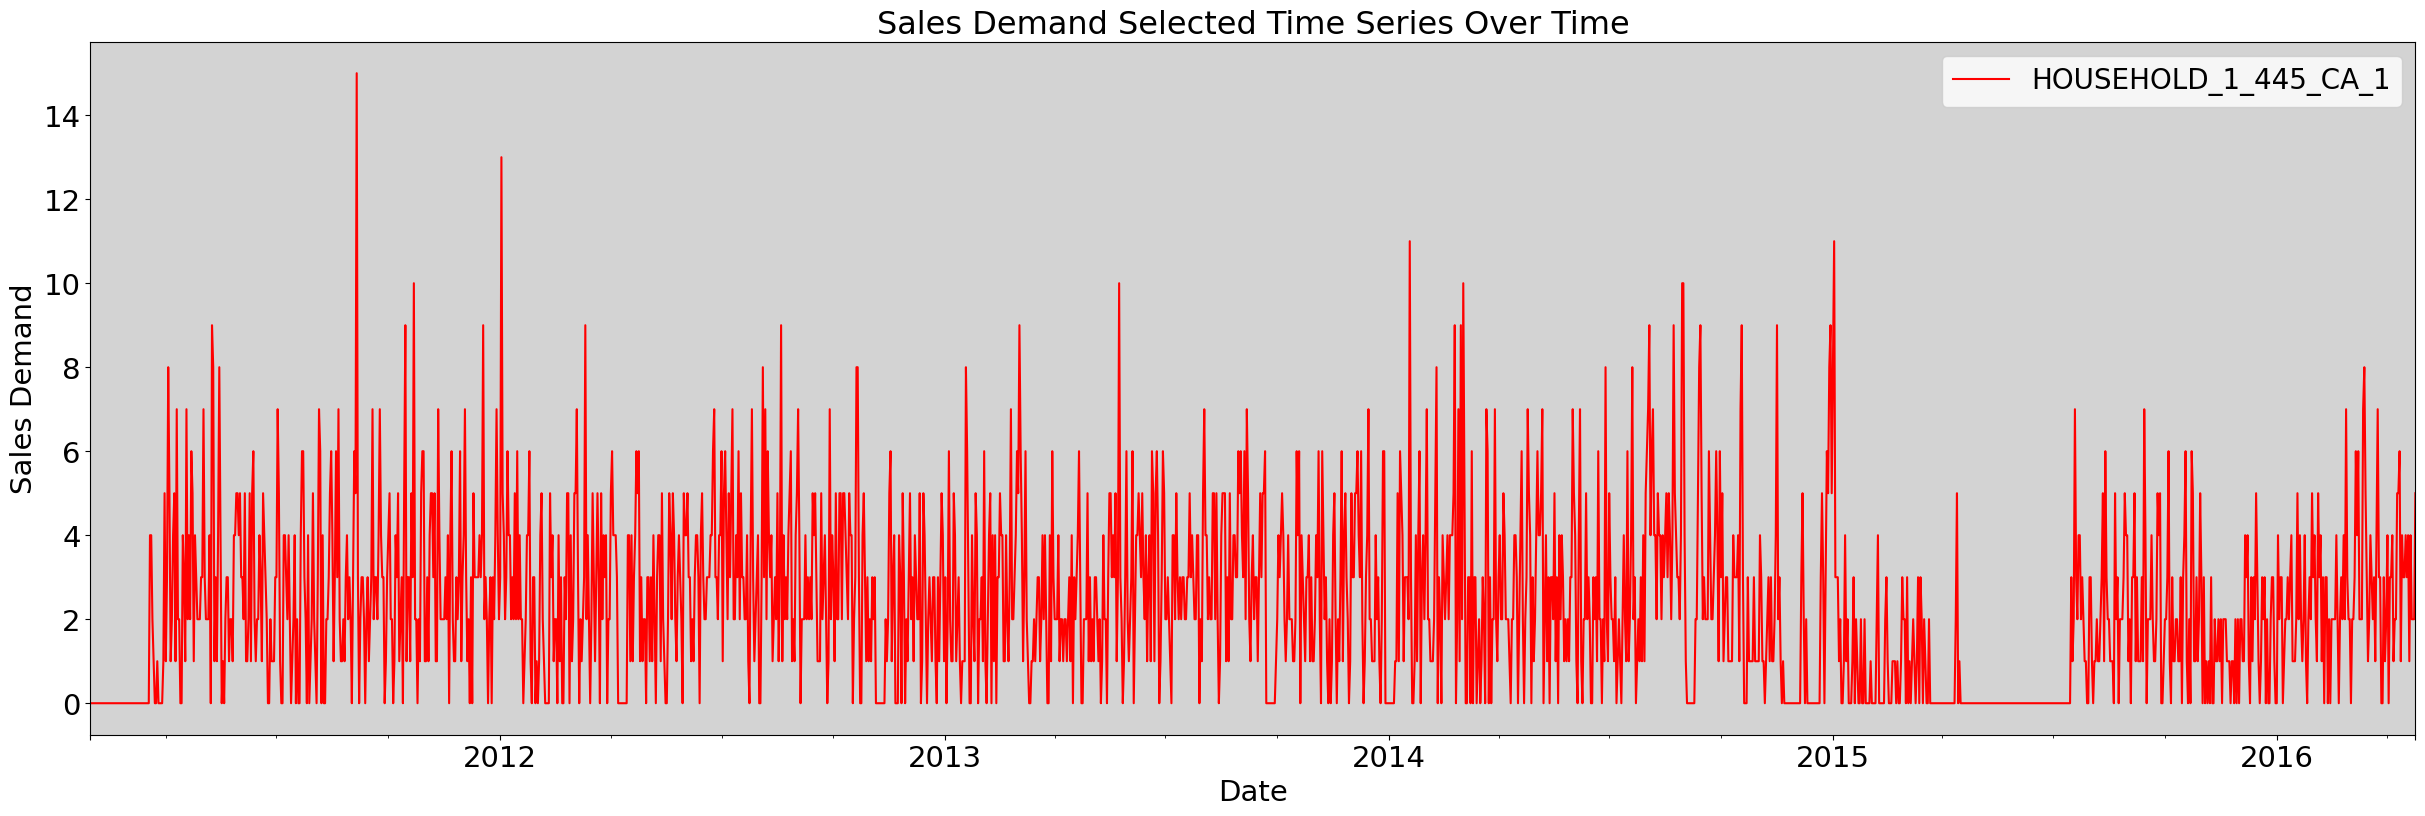

In [66]:
#Select arbitrary index and plot the time series
index = 1000
y = pd.DataFrame(sales_df.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='red')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [67]:
sales_df.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 3, 0],
       [1, 0, 1, ..., 1, 1, 0],
       [1, 0, 1, ..., 0, 3, 0]], shape=(1913, 30490))

In [72]:
"""
Global LSTM Forecasting Pipeline (M5-style)

Task:
- Train a single global LSTM model on daily sales data
- Input  : past 56 days of sales
- Output : next 28 days of sales
- Data   : (1913 days × 30490 item-store series)

This implementation is:
✔ Memory-efficient (generator-based)
✔ Scalable to 30k+ series
✔ Production-quality and well-commented
"""

# ---------------------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------------------
LOOKBACK = 56          # number of past days used as input
HORIZON = 28           # number of future days to predict
BATCH_ITEMS = 128      # number of item-series processed together
EPOCHS = 5
LEARNING_RATE = 1e-3

In [73]:
# ---------------------------------------------------------------------
# 2. SCALING (PER-SERIES NORMALIZATION)
# ---------------------------------------------------------------------
def scale_sales_dataframe(sales_df: pd.DataFrame):
    """
    Scale each item-store time series independently.
    This is critical because sales scales differ widely across items.

    Returns:
        scaled_df : scaled sales dataframe
        scalers   : dict of fitted scalers per column
    """
    scaled_df = sales_df.copy()
    scalers = {}

    for col in sales_df.columns:
        scaler = StandardScaler()
        scaled_df[col] = scaler.fit_transform(
            sales_df[[col]]
        )
        scalers[col] = scaler

    return scaled_df, scalers

In [74]:
# ---------------------------------------------------------------------
# 3. SEQUENCE GENERATOR (MEMORY-SAFE)
# ---------------------------------------------------------------------
def sequence_generator(
    sales_df: pd.DataFrame,
    lookback: int,
    horizon: int,
    batch_items: int
):
    """
    Generator that yields (X, y) batches for training.

    Each batch:
    - Selects a chunk of item-series (columns)
    - Creates sliding windows over time
    - Treats each item as an independent sample

    Output shapes:
        X -> (samples, lookback, 1)
        y -> (samples, horizon)
    """
    num_days, num_items = sales_df.shape

    # Iterate over item-series in chunks to control memory usage
    for start in range(0, num_items, batch_items):
        end = min(start + batch_items, num_items)

        # Shape: (num_days, batch_items)
        chunk = sales_df.iloc[:, start:end].values

        X_list, y_list = [], []

        # Sliding window over time dimension
        for t in range(num_days - lookback - horizon + 1):
            # Past window
            X_window = chunk[t : t + lookback]                    # (lookback, batch_items)
            # Future window
            y_window = chunk[t + lookback : t + lookback + horizon]  # (horizon, batch_items)

            # Transpose so each item becomes one training sample
            X_list.append(X_window.T)  # (batch_items, lookback)
            y_list.append(y_window.T)  # (batch_items, horizon)

        # Concatenate all windows for this chunk
        X = np.concatenate(X_list, axis=0)
        y = np.concatenate(y_list, axis=0)

        # Add feature dimension for LSTM
        yield X[..., np.newaxis], y

In [75]:
# ---------------------------------------------------------------------
# 4. MODEL DEFINITION (GLOBAL LSTM)
# ---------------------------------------------------------------------
def build_lstm_model(lookback: int, horizon: int):
    """
    Simple and robust global LSTM model.
    One model is shared across all item-store series.
    """
    model = Sequential([
        LSTM(
            units=64,
            input_shape=(lookback, 1),
            return_sequences=False
        ),
        Dense(horizon)
    ])

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss="mse"
    )

    return model

In [76]:
# ---------------------------------------------------------------------
# 5. TRAINING LOOP (STREAMED)
# ---------------------------------------------------------------------
def train_model(model, sales_df):
    """
    Custom training loop using train_on_batch.
    This avoids loading the full dataset into memory.
    """
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")

        for X_batch, y_batch in sequence_generator(
            sales_df,
            lookback=LOOKBACK,
            horizon=HORIZON,
            batch_items=BATCH_ITEMS
        ):
            model.train_on_batch(X_batch, y_batch)

In [77]:
# ---------------------------------------------------------------------
# 6. FORECASTING (NEXT 28 DAYS FOR ALL ITEMS)
# ---------------------------------------------------------------------
def forecast_next_28_days(model, sales_df_scaled, scalers):
    """
    Predict next 28 days for all item-store series.

    Returns:
        forecast : ndarray of shape (num_items, 28)
    """
    # Last LOOKBACK days for all items
    last_window = sales_df_scaled.tail(LOOKBACK).values  # (56, num_items)

    # Prepare LSTM input
    X_pred = last_window.T[..., np.newaxis]               # (num_items, 56, 1)

    # Predict in scaled space
    forecast_scaled = model.predict(X_pred, verbose=0)

    # Inverse scaling per series
    forecast = np.zeros_like(forecast_scaled)

    for i, col in enumerate(sales_df_scaled.columns):
        forecast[i] = scalers[col].inverse_transform(
            forecast_scaled[i].reshape(-1, 1)
        ).ravel()

    return forecast

In [ ]:
# ---------------------------------------------------------------------
# 7. END-TO-END EXECUTION
# ---------------------------------------------------------------------
# Assume `sales_df` is already loaded with shape (1913, 30490)

# Step 1: Scale data
sales_scaled, scalers = scale_sales_dataframe(sales_df)

# Step 2: Build model
model = build_lstm_model(LOOKBACK, HORIZON)
model.summary()

# Step 3: Train model
train_model(model, sales_scaled)

# Step 4: Forecast next 28 days
forecast_28 = forecast_next_28_days(model, sales_scaled, scalers)

print("Forecast shape:", forecast_28.shape)  # (30490, 28)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,716 (73.11 KB)

 Trainable params: 18,716 (73.11 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/5
